For the twitter sentiment analysis model, we have chosen a dataset of tweets labelled either positive or negative.
The dataset for training the model can be found in 

http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip

Description of the data set:

0 - polarity of the tweet (0 = negative, 4 = positive)<br>
1 - Id of the tweet <br>
2 - date of the tweet <br>
3 - query, If there is no query, then this value is NO_QUERY.<br>
4 - user who tweeted <br>
5 - text of the tweet.

In [69]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

First, we will assign column labels to each column

In [70]:
cols = ['sentiment','id','date','query_string','user','text']

In [71]:
df = pd.read_csv("./training.csv",header=None, names=cols)

In [72]:
df.head()

,sentiment,id,date,query_string,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   sentiment     1600000 non-null  int64 
 1   id            1600000 non-null  int64 
 2   date          1600000 non-null  object
 3   query_string  1600000 non-null  object
 4   user          1600000 non-null  object
 5   text          1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [74]:
df.sentiment.value_counts()

0    800000
4    800000
Name: sentiment, dtype: int64

Dataset has 1.6million data points.With 50%(0-799999) of data with negative label and another 50%(8000000-1600000) with positive label. There are no null entries.

In [75]:
df.query_string.value_counts()

NO_QUERY    1600000
Name: query_string, dtype: int64

We will drop the id, date , query and user name columns since wen won't need them for sentiment anzlysis.

In [76]:
df.drop(['id','date','query_string','user'],axis=1,inplace=True)

In [77]:
df.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [78]:
df[df.sentiment == 0].head(10)

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
5,0,@Kwesidei not the whole crew
6,0,Need a hug
7,0,@LOLTrish hey long time no see! Yes.. Rains a...
8,0,@Tatiana_K nope they didn't have it
9,0,@twittera que me muera ?


In [79]:
df[df.sentiment == 4].head(10)

,sentiment,text
800000,4,I LOVE @Health4UandPets u guys r the best!!
800001,4,im meeting up with one of my besties tonight! ...
800002,4,"@DaRealSunisaKim Thanks for the Twitter add, S..."
800003,4,Being sick can be really cheap when it hurts t...
800004,4,@LovesBrooklyn2 he has that effect on everyone
800005,4,@ProductOfFear You can tell him that I just bu...
800006,4,@r_keith_hill Thans for your response. Ihad al...
800007,4,"@KeepinUpWKris I am so jealous, hope you had a..."
800008,4,"@tommcfly ah, congrats mr fletcher for finally..."
800009,4,@e4VoIP I RESPONDED Stupid cat is helping me ...


 it seems like that all the negative class is from 0~799999th index,
and the positive class entries start from 800000 to the end of the dataset.

In [80]:
df[df.sentiment == 0].index

Int64Index([     0,      1,      2,      3,      4,      5,      6,      7,
                 8,      9,
            ...
            799990, 799991, 799992, 799993, 799994, 799995, 799996, 799997,
            799998, 799999],
           dtype='int64', length=800000)

In [81]:
df[df.sentiment == 4].index

Int64Index([ 800000,  800001,  800002,  800003,  800004,  800005,  800006,
             800007,  800008,  800009,
            ...
            1599990, 1599991, 1599992, 1599993, 1599994, 1599995, 1599996,
            1599997, 1599998, 1599999],
           dtype='int64', length=800000)

In order for the computation, I mapped the class value of 4(positive) to 1.

In [82]:
df['sentiment'] = df['sentiment'].map({0: 0, 4: 1})

In [83]:
df.sentiment.value_counts()

0    800000
1    800000
Name: sentiment, dtype: int64

# Data Preprocessing 

Now we will clean the data before feeding it into the model.

Below is the datacleaning function that we have defined.
The order of the cleaning is 

1. Souping-HTML DECODING
2. BOM removing-removing unrecognisable special characters
3. url address and twitter ID removals
4. converting to lower-case
6. negation handling
7. removing numbers and special characters
8. tokenizing and joining

In [2]:
import re
from bs4 import BeautifulSoup
from nltk.tokenize import WordPunctTokenizer
tok = WordPunctTokenizer()

pat1 = r'@[A-Za-z0-9_]+'
pat2 = r'https?://[^ ]+'
combined_pat = r'|'.join((pat1, pat2))
www_pat = r'www.[^ ]+'
negations_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
                "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not"}
neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')

def tweet_cleaner_updated(text):
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    try:
        bom_removed = souped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        bom_removed = souped
    stripped = re.sub(combined_pat, '', bom_removed)
    stripped = re.sub(www_pat, '', stripped)
    lower_case = stripped.lower()
    neg_handled = neg_pattern.sub(lambda x: negations_dic[x.group()], lower_case)
    letters_only = re.sub("[^a-zA-Z]", " ", neg_handled)
    # During the letters_only process two lines above, it has created unnecessay white spaces,
    # I will tokenize and join together to remove unneccessary white spaces
    words = [x for x  in tok.tokenize(letters_only) if len(x) > 1]
    return (" ".join(words)).strip()

In [5]:
df = pd.read_csv("./training.1600000.processed.noemoticon.csv",header=None,
                 usecols=[0,5],names=['sentiment','text'])
df['sentiment'] = df['sentiment'].map({0: 0, 4: 1})
df.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [7]:
%%time
print ("Cleaning the tweets...\n")
clean_tweet_texts = []
for i in range(0,len(df)):
    if( (i+1)%100000 == 0 ):
        print ("Tweets %d of %d has been processed" % ( i+1, len(df) )  )                                                                  
    clean_tweet_texts.append(tweet_cleaner_updated(df['text'][i]))

Cleaning the tweets...

Tweets 100000 of 1600000 has been processed
Tweets 200000 of 1600000 has been processed
Tweets 300000 of 1600000 has been processed
Tweets 400000 of 1600000 has been processed
Tweets 500000 of 1600000 has been processed
Tweets 600000 of 1600000 has been processed
Tweets 700000 of 1600000 has been processed


C:\Users\saiga\anaconda3\lib\site-packages\bs4\__init__.py:332: MarkupResemblesLocatorWarning: " i just received my G8 viola exam.. and its... well... .. disappointing.. :\.." looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


Tweets 800000 of 1600000 has been processed
Tweets 900000 of 1600000 has been processed
Tweets 1000000 of 1600000 has been processed
Tweets 1100000 of 1600000 has been processed
Tweets 1200000 of 1600000 has been processed


C:\Users\saiga\anaconda3\lib\site-packages\bs4\__init__.py:332: MarkupResemblesLocatorWarning: "E3 ON PLAYSTATION HOME IN ABOUT AN HOUR!!!!!!!!!! \../  \../" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


Tweets 1300000 of 1600000 has been processed
Tweets 1400000 of 1600000 has been processed
Tweets 1500000 of 1600000 has been processed
Tweets 1600000 of 1600000 has been processed
Wall time: 5min 19s


In [8]:
clean_df = pd.DataFrame(clean_tweet_texts,columns=['text'])
clean_df['target'] = df.sentiment
clean_df.to_csv('clean_tweet.csv',encoding='utf-8')

In [9]:
csv = 'clean_tweet.csv'
my_df = pd.read_csv(csv,index_col=0)
my_df.head()

C:\Users\saiga\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,text,target
0,awww that bummer you shoulda got david carr of...,0
1,is upset that he can not update his facebook b...,0
2,dived many times for the ball managed to save ...,0
3,my whole body feels itchy and like its on fire,0
4,no it not behaving at all mad why am here beca...,0


In [10]:
my_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1600000 entries, 0 to 1599999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   text    1596041 non-null  object
 1   target  1600000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 36.6+ MB


In [11]:
my_df[my_df.isnull().any(axis=1)].head()

,text,target
208,NaN,0
249,NaN,0
282,NaN,0
398,NaN,0
430,NaN,0


In [12]:
np.sum(my_df.isnull().any(axis=1))

3959

In [13]:
my_df.isnull().any(axis=0)

text       True
target    False
dtype: bool

It lookos like 3,981 entries have null entries for the text column. So, we decided to discard for the sentiment analysis, so we are dropping these null rows, and updating the data frame.

In [16]:
my_df.dropna(inplace=True)
my_df.reset_index(drop=True,inplace=True)
my_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1596041 entries, 0 to 1596040
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   text    1596041 non-null  object
 1   target  1596041 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


# Visualizing the Corpus--Word Cloud


To provides a general idea of what kind of words are frequent in the corpus, we have used wordcloud to get some rudimentary idea about the dataset. We are using word cloud library to generate the visual model. First we will see among negative tweets which words appear more frequent.

In [14]:
neg_tweets = my_df[my_df.target == 0]
neg_string = []
for t in neg_tweets.text:
    neg_string.append(t)
neg_string = pd.Series(neg_string).str.cat(sep=' ')

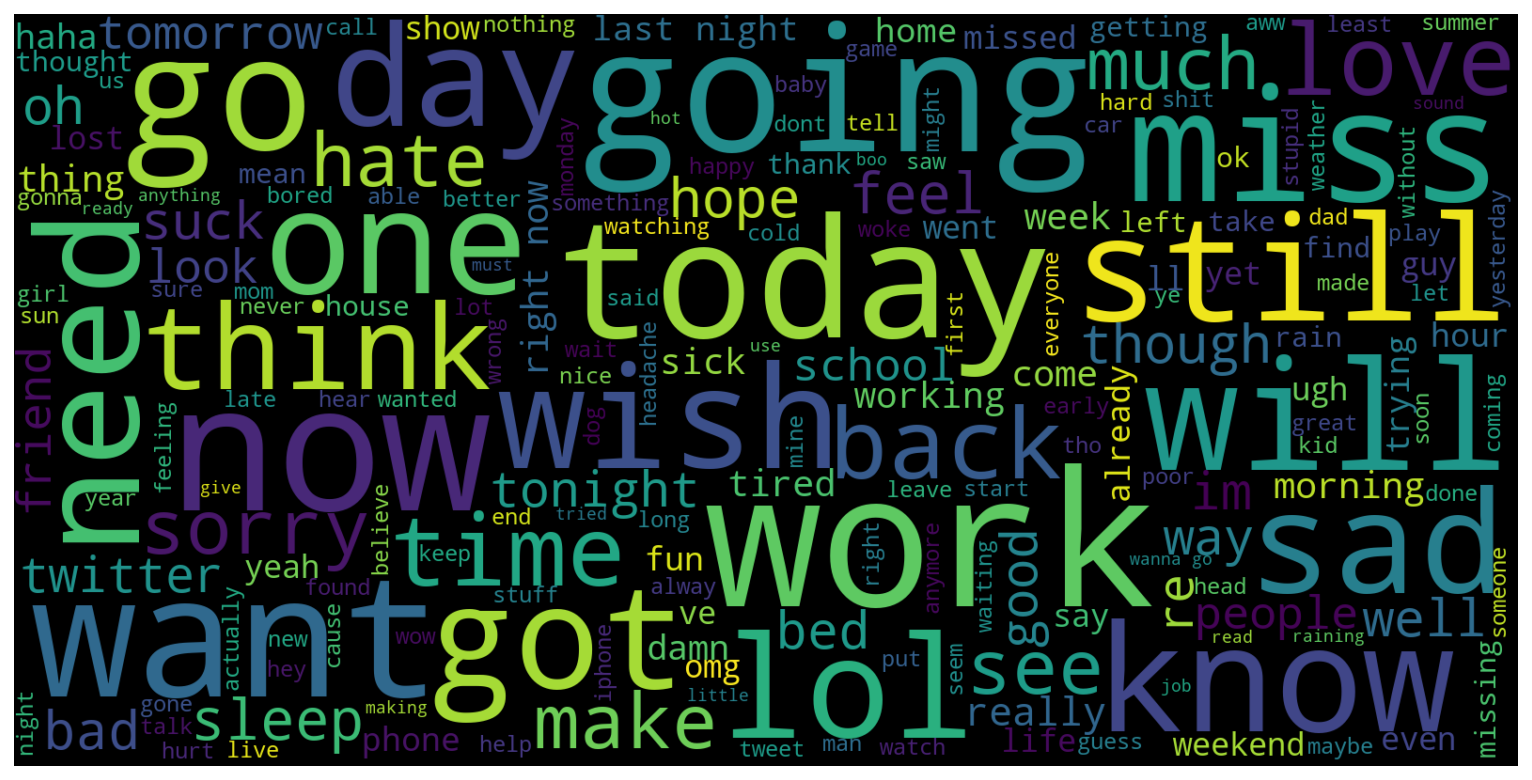

In [15]:
from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(neg_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

today","now" seems to be repeated a lot these are neutral words, so it is common for them to appear more frequent.
and we can see that some of the words in smaller size like damn","ugh","miss","bad" whcih seem to be in negative tweets,



Now among positive tweets.

In [22]:
pos_tweets = my_df[my_df.target == 1]
pos_string = []
for t in pos_tweets.text:
    pos_string.append(t)
pos_string = pd.Series(pos_string).str.cat(sep=' ')

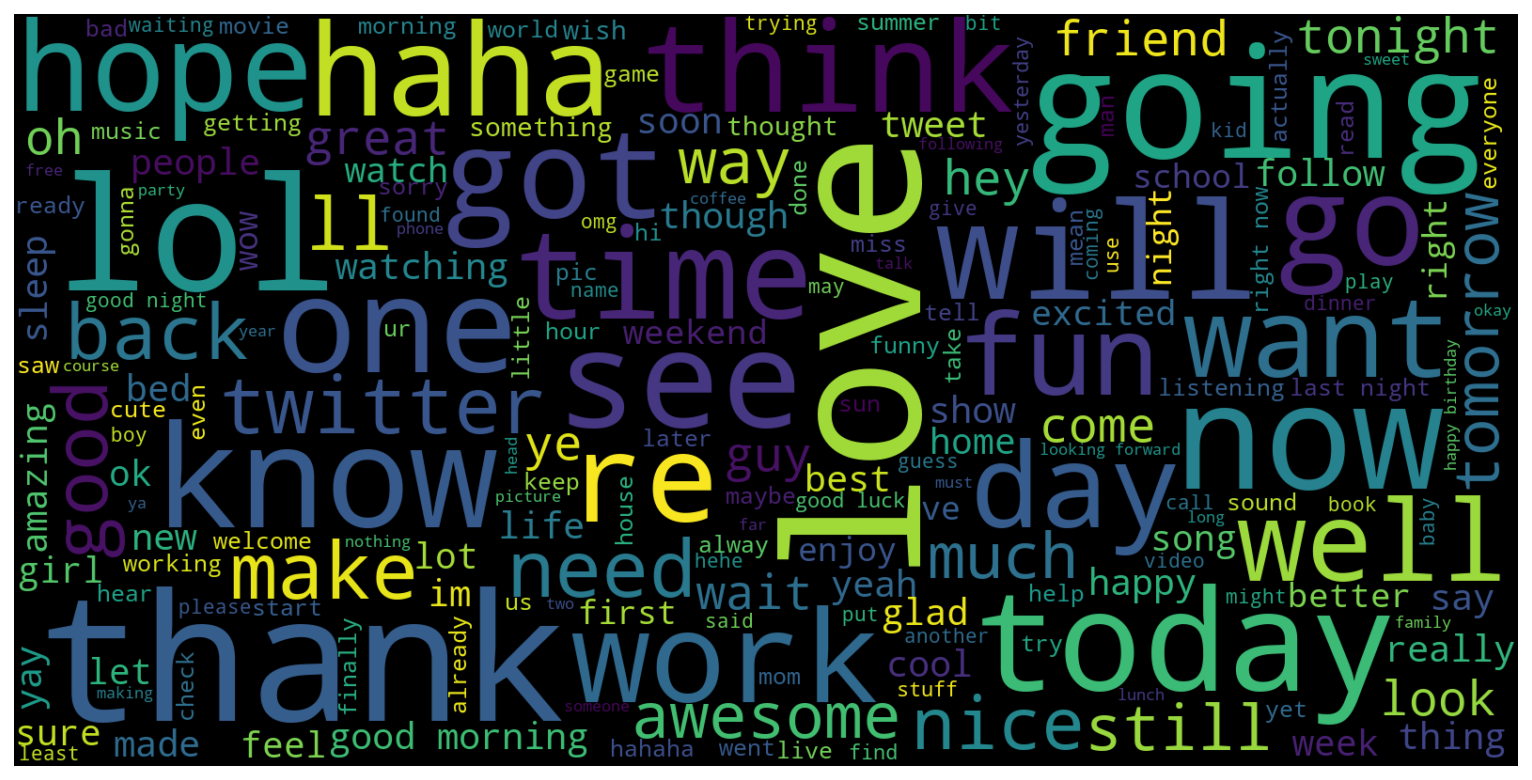

In [23]:
wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(pos_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Again "today","now" seems to be repeated a lot. 

## Splitting the dataset into Training /Validation/Testing data

The ratio we decided to split my data is 98/1/1, 98% of data as the training set, and 1% for the dev set, and the final 1% for the test set. The reason behind this is, since the data set has 1.6 million entreis . So, even 1% of it makes around 15,000 entries which is sufficient for evaluating the model.

In [20]:
x = my_df.text
y = my_df.target

In [21]:
from sklearn.model_selection import train_test_split
SEED = 2000
x_train, x_validation_and_test, y_train, y_validation_and_test = train_test_split(x, y, test_size=.02, random_state=SEED)
x_validation, x_test, y_validation, y_test = train_test_split(x_validation_and_test, y_validation_and_test, test_size=.5, random_state=SEED)

In [22]:
print ("Train set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_train),
                                                                             (len(x_train[y_train == 0]) / (len(x_train)*1.))*100,
                                                                            (len(x_train[y_train == 1]) / (len(x_train)*1.))*100))
print ("Validation set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_validation),
                                                                             (len(x_validation[y_validation == 0]) / (len(x_validation)*1.))*100,
                                                                            (len(x_validation[y_validation == 1]) / (len(x_validation)*1.))*100))
print ("Test set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_test),
                                                                             (len(x_test[y_test == 0]) / (len(x_test)*1.))*100,
                                                                            (len(x_test[y_test == 1]) / (len(x_test)*1.))*100))

Train set has total 1564120 entries with 50.02% negative, 49.98% positive
Validation set has total 15960 entries with 49.45% negative, 50.55% positive
Test set has total 15961 entries with 49.68% negative, 50.32% positive


## Baseline

A common baseline is the Zero Rule. This classifier predicts categories with the maximum number of items. As we can see from the above validation set classification, the majority class division is negative with 50.40 percent, but it can be used to set a baseline performance as a standard for other classification systems based on the same data, which shows that, the prediction of negative value for each validation of data we will get same percentage of accuracy.




Another option is to compare the validation results with the TextBlob. Textblob is a Python library for processing text data. In addition to other useful tools such as part-of-speech tagging and Ngram, the package has an integrated emotion classification. It's a ready-to-use sentiment analysis tool. In addition to having zero accuracy, let's take a look at the accuracy gained from TextBlob sentiment analysis to see how the model works.

In [23]:
from textblob import TextBlob
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

In [24]:
%%time
tbresult = [TextBlob(i).sentiment.polarity for i in x_validation]
tbpred = [0 if n < 0 else 1 for n in tbresult]

Wall time: 1.64 s


In [25]:
conmat = np.array(confusion_matrix(y_validation, tbpred, labels=[1,0]))

confusion = pd.DataFrame(conmat, index=['positive', 'negative'],
                         columns=['predicted_positive','predicted_negative'])
print ("Accuracy Score: {0:.2f}%".format(accuracy_score(y_validation, tbpred)*100))
print ("-"*80)
print ("Confusion Matrix\n")
print (confusion)
print ("-"*80)
print ("Classification Report\n")
print (classification_report(y_validation, tbpred))

Accuracy Score: 61.84%
--------------------------------------------------------------------------------
Confusion Matrix

          predicted_positive  predicted_negative
positive                7282                 785
negative                5306                2587
--------------------------------------------------------------------------------
Classification Report

              precision    recall  f1-score   support

           0       0.77      0.33      0.46      7893
           1       0.58      0.90      0.71      8067

    accuracy                           0.62     15960
   macro avg       0.67      0.62      0.58     15960
weighted avg       0.67      0.62      0.58     15960



TextBlob sentiment analysis yielded 60.65% accuracy on the validation set, which is 10.25% more accurate than null accuracy (50.40%).

## Feature Extraction

### Count Vectorizer

We use sklearn.feature extraction.text.CountVectorizer to convert a collection of text documents to a matrix of token counts. This implementation produces a sparse representation of the counts.

But if the size of the corpus gets big, the number of vocabulary gets too big to process. With my 1.5 million tweets, if we  build vocabulary without limiting the number of vocabulary, we will have more than 260,000 vocabularies. So we decided to limit the number of vocabularies, but we also wanted to see how the performance varies depending on the number of vocabularies.

Another thing we want to explore is stopwords. To see if presence or absence of stopwords will have any affect on performance of the model

A model we chose to evaluate different count vectors is the logistic regression. It is one of the linear models, so computationally scalable to big data, compared to models like KNN or random forest.

In [26]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from time import time

Below I define two functions to iteratively train on a different number of features, then check the accuracy of logistic regression on the validation set.

In [27]:
def accuracy_summary(pipeline, x_train, y_train, x_test, y_test):
    if len(x_test[y_test == 0]) / (len(x_test)*1.) > 0.5:
        null_accuracy = len(x_test[y_test == 0]) / (len(x_test)*1.)
    else:
        null_accuracy = 1. - (len(x_test[y_test == 0]) / (len(x_test)*1.))
    t0 = time()
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
    train_test_time = time() - t0
    accuracy = accuracy_score(y_test, y_pred)
    print ("null accuracy: {0:.2f}%".format(null_accuracy*100))
    print ("accuracy score: {0:.2f}%".format(accuracy*100))
    if accuracy > null_accuracy:
        print ("model is {0:.2f}% more accurate than null accuracy".format((accuracy-null_accuracy)*100))
    elif accuracy == null_accuracy:
        print ("model has the same accuracy with the null accuracy")
    else:
        print ("model is {0:.2f}% less accurate than null accuracy".format((null_accuracy-accuracy)*100))
    print ("train and test time: {0:.2f}s".format(train_test_time))
    print ("-"*80)
    return accuracy, train_test_time

In [28]:
cvec = CountVectorizer()
lr = LogisticRegression()
n_features = np.arange(10000,100001,10000)

def nfeature_accuracy_checker(vectorizer=cvec, n_features=n_features, stop_words=None, ngram_range=(1, 1), classifier=lr):
    result = []
    print (classifier)
    print ("\n")
    for n in n_features:
        vectorizer.set_params(stop_words=stop_words, max_features=n, ngram_range=ngram_range)
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', classifier)
        ])
        print ("Validation result for {} features".format(n))
        nfeature_accuracy,tt_time = accuracy_summary(checker_pipeline, x_train, y_train, x_validation, y_validation)
        result.append((n,nfeature_accuracy,tt_time))
    return result

#### Unigram

In [30]:
%%time
print ("RESULT FOR UNIGRAM WITHOUT STOP WORDS\n")
feature_result_wosw = nfeature_accuracy_checker(stop_words='english')

RESULT FOR UNIGRAM WITHOUT STOP WORDS

LogisticRegression()


Validation result for 10000 features


C:\Users\saiga\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 50.55%
accuracy score: 77.27%
model is 26.73% more accurate than null accuracy
train and test time: 24.43s
--------------------------------------------------------------------------------
Validation result for 20000 features


C:\Users\saiga\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 50.55%
accuracy score: 77.73%
model is 27.19% more accurate than null accuracy
train and test time: 24.29s
--------------------------------------------------------------------------------
Validation result for 30000 features


C:\Users\saiga\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 50.55%
accuracy score: 77.62%
model is 27.07% more accurate than null accuracy
train and test time: 24.65s
--------------------------------------------------------------------------------
Validation result for 40000 features


C:\Users\saiga\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 50.55%
accuracy score: 77.73%
model is 27.18% more accurate than null accuracy
train and test time: 24.79s
--------------------------------------------------------------------------------
Validation result for 50000 features


C:\Users\saiga\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 50.55%
accuracy score: 77.73%
model is 27.19% more accurate than null accuracy
train and test time: 24.72s
--------------------------------------------------------------------------------
Validation result for 60000 features


C:\Users\saiga\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 50.55%
accuracy score: 77.72%
model is 27.17% more accurate than null accuracy
train and test time: 25.82s
--------------------------------------------------------------------------------
Validation result for 70000 features


C:\Users\saiga\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 50.55%
accuracy score: 77.67%
model is 27.12% more accurate than null accuracy
train and test time: 26.40s
--------------------------------------------------------------------------------
Validation result for 80000 features


C:\Users\saiga\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 50.55%
accuracy score: 77.81%
model is 27.27% more accurate than null accuracy
train and test time: 25.48s
--------------------------------------------------------------------------------
Validation result for 90000 features


C:\Users\saiga\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 50.55%
accuracy score: 77.68%
model is 27.14% more accurate than null accuracy
train and test time: 25.21s
--------------------------------------------------------------------------------
Validation result for 100000 features
null accuracy: 50.55%
accuracy score: 77.73%
model is 27.18% more accurate than null accuracy
train and test time: 25.26s
--------------------------------------------------------------------------------
Wall time: 4min 11s


C:\Users\saiga\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [32]:
%%time
print ("RESULT FOR UNIGRAM WITH STOP WORDS\n")
feature_result_ug = nfeature_accuracy_checker()

RESULT FOR UNIGRAM WITH STOP WORDS

LogisticRegression()


Validation result for 10000 features


C:\Users\saiga\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 50.55%
accuracy score: 79.60%
model is 29.05% more accurate than null accuracy
train and test time: 26.14s
--------------------------------------------------------------------------------
Validation result for 20000 features


C:\Users\saiga\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 50.55%
accuracy score: 79.82%
model is 29.28% more accurate than null accuracy
train and test time: 25.93s
--------------------------------------------------------------------------------
Validation result for 30000 features


C:\Users\saiga\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 50.55%
accuracy score: 79.94%
model is 29.40% more accurate than null accuracy
train and test time: 26.02s
--------------------------------------------------------------------------------
Validation result for 40000 features


C:\Users\saiga\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 50.55%
accuracy score: 79.96%
model is 29.42% more accurate than null accuracy
train and test time: 26.56s
--------------------------------------------------------------------------------
Validation result for 50000 features


C:\Users\saiga\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 50.55%
accuracy score: 79.76%
model is 29.21% more accurate than null accuracy
train and test time: 26.33s
--------------------------------------------------------------------------------
Validation result for 60000 features


C:\Users\saiga\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 50.55%
accuracy score: 79.96%
model is 29.42% more accurate than null accuracy
train and test time: 27.26s
--------------------------------------------------------------------------------
Validation result for 70000 features


C:\Users\saiga\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 50.55%
accuracy score: 79.88%
model is 29.34% more accurate than null accuracy
train and test time: 27.27s
--------------------------------------------------------------------------------
Validation result for 80000 features


C:\Users\saiga\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 50.55%
accuracy score: 79.84%
model is 29.29% more accurate than null accuracy
train and test time: 27.97s
--------------------------------------------------------------------------------
Validation result for 90000 features


C:\Users\saiga\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 50.55%
accuracy score: 79.84%
model is 29.29% more accurate than null accuracy
train and test time: 30.53s
--------------------------------------------------------------------------------
Validation result for 100000 features
null accuracy: 50.55%
accuracy score: 79.94%
model is 29.40% more accurate than null accuracy
train and test time: 30.67s
--------------------------------------------------------------------------------
Wall time: 4min 34s


C:\Users\saiga\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [47]:
csv = 'term_freq_df.csv'
term_freq_df = pd.read_csv(csv,index_col=0)
term_freq_df.sort_values(by='total', ascending=False).iloc[:10]

,negative,positive,total
to,313160,252566,565726
the,257836,265998,523834
my,190774,125955,316729
it,157448,147786,305234
and,153958,149642,303600
you,103844,198245,302089
not,194724,86865,281589
is,133435,111191,244626
in,115541,101160,216701
for,98999,117369,216368


In [60]:
from sklearn.feature_extraction import text

a = frozenset(list(term_freq_df.sort_values(by='total', ascending=False).iloc[:10].index))
b = text.ENGLISH_STOP_WORDS
set(a).issubset(set(b))

True

In [61]:
my_stop_words = frozenset(list(term_freq_df.sort_values(by='total', ascending=False).iloc[:10].index))

In [62]:
%%time
print "RESULT FOR UNIGRAM WITHOUT CUSTOM STOP WORDS (Top 10 frequent words)\n"
feature_result_wocsw = nfeature_accuracy_checker(stop_words=my_stop_words)

RESULT FOR UNIGRAM WITHOUT CUSTOM STOP WORDS (Top 10 frequent words)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


Validation result for 10000 features
null accuracy: 50.40%
accuracy score: 79.11%
model is 28.71% more accurate than null accuracy
train and test time: 80.89s
--------------------------------------------------------------------------------
Validation result for 20000 features
null accuracy: 50.40%
accuracy score: 79.28%
model is 28.88% more accurate than null accuracy
train and test time: 92.02s
--------------------------------------------------------------------------------
Validation result for 30000 features
null accuracy: 50.40%
accuracy score: 79.39%
model is 28.98% more accurate than null accuracy
train and test time: 112.18s
-----------------------

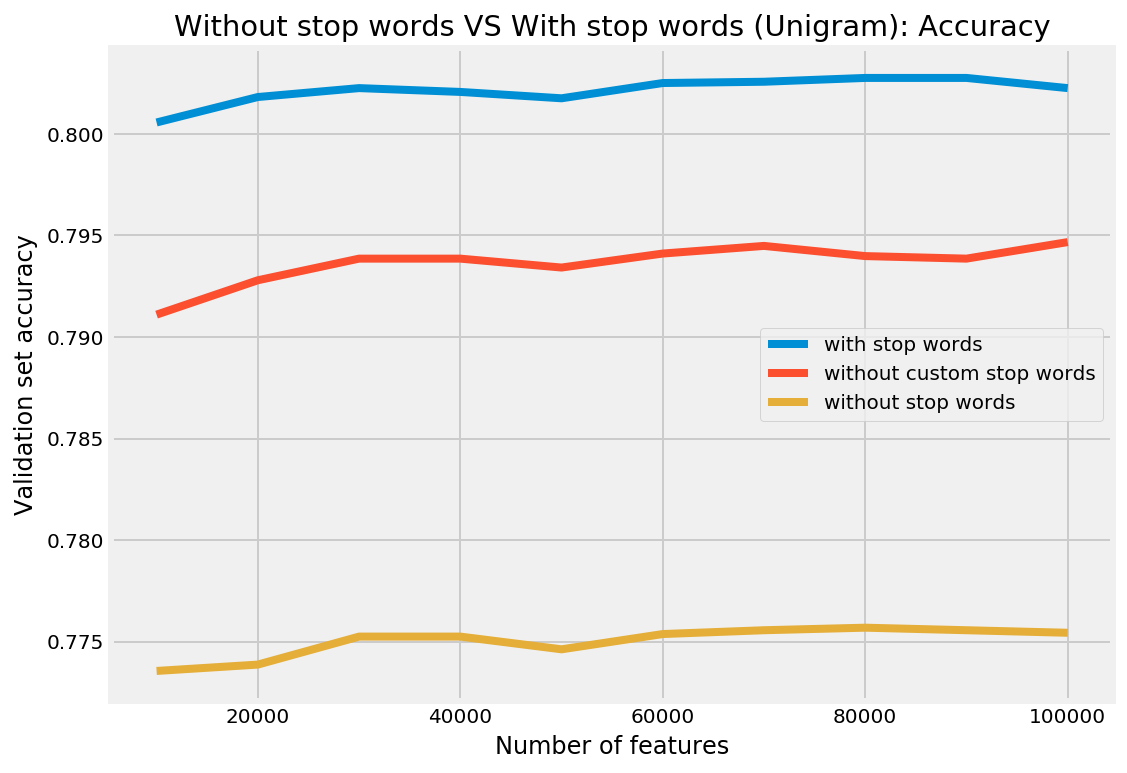

In [63]:
nfeatures_plot_ug = pd.DataFrame(feature_result_ug,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_ug_wocsw = pd.DataFrame(feature_result_wocsw,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_ug_wosw = pd.DataFrame(feature_result_wosw,columns=['nfeatures','validation_accuracy','train_test_time'])

plt.figure(figsize=(8,6))
plt.plot(nfeatures_plot_ug.nfeatures, nfeatures_plot_ug.validation_accuracy, label='with stop words')
plt.plot(nfeatures_plot_ug_wocsw.nfeatures, nfeatures_plot_ug_wocsw.validation_accuracy,label='without custom stop words')
plt.plot(nfeatures_plot_ug_wosw.nfeatures, nfeatures_plot_ug_wosw.validation_accuracy,label='without stop words')
plt.title("Without stop words VS With stop words (Unigram): Accuracy")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()

So from the graph, we can see that even if we remove the  stop words it didn't improve the model performance,but if we keep the sotpwords it resulted in better performance. So going by empirical findings we decided to keep the stop words.

## Models Comparison

In [35]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import  MultinomialNB
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron
from sklearn.neighbors import NearestCentroid
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_extraction.text import TfidfVectorizer

names = ["Logistic Regression", "Linear SVC", "LinearSVC with L1-based feature selection","MultinomialNB()", 
          "Perceptron", "Nearest Centroid"]
classifiers = [
    LogisticRegression(),
    LinearSVC(),
    Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False))),
  ('classification', LinearSVC(penalty="l2"))]),
    MultinomialNB(),
    Perceptron(),
    NearestCentroid()
    ]
zipped_clf = zip(names,classifiers)

In [36]:
tvec = TfidfVectorizer()
def classifier_comparator(vectorizer=tvec, n_features=10000, stop_words=None, ngram_range=(1, 1), classifier=zipped_clf):
    result = []
    vectorizer.set_params(stop_words=stop_words, max_features=n_features, ngram_range=ngram_range)
    for n,c in classifier:
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', c)
        ])
        print ("Validation result for {}".format(n))
        print (c)
        clf_accuracy,tt_time = accuracy_summary(checker_pipeline, x_train, y_train, x_validation, y_validation)
        result.append((n,clf_accuracy,tt_time))
    return result

In [37]:
%%time
trigram_result = classifier_comparator(n_features=100000,ngram_range=(1,3))

Validation result for Logistic Regression
LogisticRegression()


C:\Users\saiga\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 50.55%
accuracy score: 82.28%
model is 31.74% more accurate than null accuracy
train and test time: 109.93s
--------------------------------------------------------------------------------
Validation result for Linear SVC
LinearSVC()
null accuracy: 50.55%
accuracy score: 82.34%
model is 31.80% more accurate than null accuracy
train and test time: 121.81s
--------------------------------------------------------------------------------
Validation result for LinearSVC with L1-based feature selection
Pipeline(steps=[('feature_selection',
                 SelectFromModel(estimator=LinearSVC(dual=False,
                                                     penalty='l1'))),
                ('classification', LinearSVC())])
null accuracy: 50.55%
accuracy score: 82.34%
model is 31.80% more accurate than null accuracy
train and test time: 210.74s
--------------------------------------------------------------------------------
Validation result for MultinomialNB()
MultinomialNB()
nu

In [39]:
from sklearn.ensemble import VotingClassifier

clf1 = LogisticRegression()
clf2 = LinearSVC()
clf3 = MultinomialNB()


eclf = VotingClassifier(estimators=[('lr', clf1), ('svc', clf2), ('gb', clf3)], voting='hard')

for clf, label in zip([clf1, clf2, clf3, eclf], ['Logistic Regression', 'Linear SVC', 'Multinomial NB', 'Ensemble']):
    checker_pipeline = Pipeline([
            ('vectorizer', TfidfVectorizer(max_features=100000,ngram_range=(1, 3))),
            ('classifier', clf)
        ])
    print ("Validation result for {}".format(label))
    print (clf)
    clf_accuracy,tt_time = accuracy_summary(checker_pipeline, x_train, y_train, x_validation, y_validation)

Validation result for Logistic Regression
LogisticRegression()


C:\Users\saiga\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 50.55%
accuracy score: 82.28%
model is 31.74% more accurate than null accuracy
train and test time: 111.19s
--------------------------------------------------------------------------------
Validation result for Linear SVC
LinearSVC()
null accuracy: 50.55%
accuracy score: 82.34%
model is 31.80% more accurate than null accuracy
train and test time: 118.60s
--------------------------------------------------------------------------------
Validation result for Multinomial NB
MultinomialNB()
null accuracy: 50.55%
accuracy score: 80.19%
model is 29.65% more accurate than null accuracy
train and test time: 94.89s
--------------------------------------------------------------------------------
Validation result for Ensemble
VotingClassifier(estimators=[('lr', LogisticRegression()), ('svc', LinearSVC()),
                             ('gb', MultinomialNB())])


C:\Users\saiga\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 50.55%
accuracy score: 82.28%
model is 31.74% more accurate than null accuracy
train and test time: 136.11s
--------------------------------------------------------------------------------


It seems like the voting classifier does no better than the simple logistic regression model. Thus later part, I will try to finetune logistic regression model.

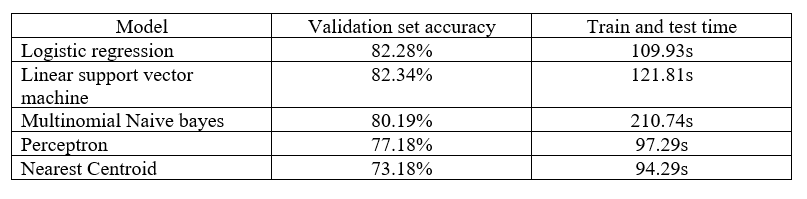

## Word vectors extracted from pre-trained Google News Word2Vec (Average/Sum)

These word vectors are trained using Word2Vec model on Google News dataset (about 100 billion words) and published by Google. The model contains 300-dimensional vectors for 3 million words and phrases. 

In [39]:
import gensim.downloader as api
googlenews = api.load("word2vec-google-news-300")

In [40]:
train_vecs_googlenews_mean = scale(np.concatenate([get_w2v_general(z, 300, googlenews,'mean') for z in x_train]))
validation_vecs_googlenews_mean = scale(np.concatenate([get_w2v_general(z, 300, googlenews,'mean') for z in x_validation]))

In [41]:
%%time
clf = LogisticRegression()
clf.fit(train_vecs_googlenews_mean, y_train)

CPU times: user 1min 14s, sys: 1min 36s, total: 2min 50s
Wall time: 53.6 s


LogisticRegression()

In [42]:
clf.score(validation_vecs_googlenews_mean, y_validation)

0.7521929824561403

In [43]:
train_vecs_googlenews_sum = scale(np.concatenate([get_w2v_general(z, 300, googlenews,'sum') for z in x_train]))
validation_vecs_googlenews_sum = scale(np.concatenate([get_w2v_general(z, 300, googlenews,'sum') for z in x_validation]))

In [44]:
%%time
clf = LogisticRegression()
clf.fit(train_vecs_googlenews_sum, y_train)

CPU times: user 2min 6s, sys: 6min, total: 8min 7s
Wall time: 6min 21s


LogisticRegression()

In [45]:
clf.score(validation_vecs_googlenews_sum, y_validation)

0.7513784461152883

this is trained with Google News, thus it is hard to comapre each other directly. What if Word2Vec is specifically trained with Tweets?

## Separately training Word2Vec  

we have trained two Word2Vec models using CBOW (Continuous Bag Of Words) and Skip Gram models. In terms of parameter setting, we set the same parameters I used for Doc2Vec.

- size of vectors: 100 dimensions
- negative sampling: 5
- window: 2
- minimum word count: 2
- alpha: 0.065 (decrease alpha by 0.002 per epoch)
- number of epochs: 30

With above settings, we defined CBOW model by passing "sg=0", and Skip Gram model by passing "sg=1".

And once we get the results from two models, we concatenate vectors of two models for each word so that the concatenated vectors will have 200 dimensional representation of each word.

In [46]:
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
import gensim
from gensim.models.word2vec import Word2Vec
from gensim.models.doc2vec import TaggedDocument
import multiprocessing
from sklearn import utils

In [47]:
def labelize_tweets_ug(tweets,label):
    result = []
    prefix = label
    for i, t in zip(tweets.index, tweets):
        result.append(TaggedDocument(t.split(), [prefix + '_%s' % i]))
    return result

In [48]:
all_x = pd.concat([x_train,x_validation,x_test])
all_x_w2v = labelize_tweets_ug(all_x, 'all')

In [49]:
cores = multiprocessing.cpu_count()
model_ug_cbow = Word2Vec(sg=0, size=100, negative=5, window=2, min_count=2, workers=cores, alpha=0.065, min_alpha=0.065)
model_ug_cbow.build_vocab([x.words for x in tqdm(all_x_w2v)])

100%|████████████████████████████| 1596041/1596041 [00:01<00:00, 1091515.36it/s]


In [50]:
%%time
for epoch in range(30):
    model_ug_cbow.train(utils.shuffle([x.words for x in tqdm(all_x_w2v)]), total_examples=len(all_x_w2v), epochs=1)
    model_ug_cbow.alpha -= 0.002
    model_ug_cbow.min_alpha = model_ug_cbow.alpha

100%|████████████████████████████| 1596041/1596041 [00:01<00:00, 1278090.44it/s]


CPU times: user 17min 19s, sys: 5min 25s, total: 22min 45s
Wall time: 13min 44s


In [51]:
train_vecs_cbow_mean = scale(np.concatenate([get_w2v_general(z, 100, model_ug_cbow,'mean') for z in x_train]))
validation_vecs_cbow_mean = scale(np.concatenate([get_w2v_general(z, 100, model_ug_cbow,'mean') for z in x_validation]))

/var/folders/wh/3sfw8mdj5fl8gf63gvc938kw0000gn/T/ipykernel_6944/961074148.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vec += vectors[word].reshape((1, size))
/var/folders/wh/3sfw8mdj5fl8gf63gvc938kw0000gn/T/ipykernel_6944/961074148.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vec += vectors[word].reshape((1, size))


In [52]:
%%time
clf = LogisticRegression()
clf.fit(train_vecs_cbow_mean, y_train)

CPU times: user 27 s, sys: 3.07 s, total: 30.1 s
Wall time: 4.09 s


LogisticRegression()

In [53]:
clf.score(validation_vecs_cbow_mean, y_validation)

0.7580827067669172

In [54]:
model_ug_sg = Word2Vec(sg=1, size=100, negative=5, window=2, min_count=2, workers=cores, alpha=0.065, min_alpha=0.065)
model_ug_sg.build_vocab([x.words for x in tqdm(all_x_w2v)])

100%|█████████████████████████████| 1596041/1596041 [00:02<00:00, 748043.36it/s]


In [55]:
%%time
for epoch in range(30):
    model_ug_sg.train(utils.shuffle([x.words for x in tqdm(all_x_w2v)]), total_examples=len(all_x_w2v), epochs=1)
    model_ug_sg.alpha -= 0.002
    model_ug_sg.min_alpha = model_ug_sg.alpha

100%|████████████████████████████| 1596041/1596041 [00:01<00:00, 1403879.14it/s]


CPU times: user 32min 59s, sys: 4min 34s, total: 37min 33s
Wall time: 12min 59s


In [56]:
train_vecs_sg_mean = scale(np.concatenate([get_w2v_general(z, 100, model_ug_sg,'mean') for z in x_train]))
validation_vecs_sg_mean = scale(np.concatenate([get_w2v_general(z, 100, model_ug_sg,'mean') for z in x_validation]))

/var/folders/wh/3sfw8mdj5fl8gf63gvc938kw0000gn/T/ipykernel_6944/961074148.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vec += vectors[word].reshape((1, size))
/var/folders/wh/3sfw8mdj5fl8gf63gvc938kw0000gn/T/ipykernel_6944/961074148.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vec += vectors[word].reshape((1, size))


In [57]:
%%time
clf = LogisticRegression()
clf.fit(train_vecs_sg_mean, y_train)

CPU times: user 13.7 s, sys: 2.03 s, total: 15.7 s
Wall time: 2.5 s


LogisticRegression()

In [58]:
clf.score(validation_vecs_sg_mean, y_validation)

0.7606516290726817

In [59]:
def get_w2v_mean(tweet, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tweet.split():
        try:
            vec += np.append(model_ug_cbow[word],model_ug_sg[word]).reshape((1, size))
            count += 1.
        except KeyError:
            continue
    if count != 0:
        vec /= count
    return vec

In [60]:
train_vecs_cbowsg_mean = scale(np.concatenate([get_w2v_mean(z, 200) for z in x_train]))
validation_vecs_cbowsg_mean = scale(np.concatenate([get_w2v_mean(z, 200) for z in x_validation]))

/var/folders/wh/3sfw8mdj5fl8gf63gvc938kw0000gn/T/ipykernel_6944/3984318935.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vec += np.append(model_ug_cbow[word],model_ug_sg[word]).reshape((1, size))
/var/folders/wh/3sfw8mdj5fl8gf63gvc938kw0000gn/T/ipykernel_6944/3984318935.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vec += np.append(model_ug_cbow[word],model_ug_sg[word]).reshape((1, size))


In [61]:
%%time
clf = LogisticRegression()
clf.fit(train_vecs_cbowsg_mean, y_train)

CPU times: user 1min 47s, sys: 10.4 s, total: 1min 58s
Wall time: 18.2 s


/Users/shivanimadhunala/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [62]:
clf.score(validation_vecs_cbowsg_mean, y_validation)

0.7664786967418546

In [63]:
def get_w2v_sum(tweet, size):
    vec = np.zeros(size).reshape((1, size))
    for word in tweet.split():
        try:
            vec += np.append(model_ug_cbow[word],model_ug_sg[word]).reshape((1, size))
        except KeyError:
            continue
    return vec

In [64]:
train_vecs_cbowsg_sum = scale(np.concatenate([get_w2v_sum(z, 200) for z in x_train]))
validation_vecs_cbowsg_sum = scale(np.concatenate([get_w2v_sum(z, 200) for z in x_validation]))

/var/folders/wh/3sfw8mdj5fl8gf63gvc938kw0000gn/T/ipykernel_6944/1858165643.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vec += np.append(model_ug_cbow[word],model_ug_sg[word]).reshape((1, size))
/var/folders/wh/3sfw8mdj5fl8gf63gvc938kw0000gn/T/ipykernel_6944/1858165643.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vec += np.append(model_ug_cbow[word],model_ug_sg[word]).reshape((1, size))


In [65]:
%%time
clf = LogisticRegression()
clf.fit(train_vecs_cbowsg_sum, y_train)

CPU times: user 1min 58s, sys: 13.9 s, total: 2min 12s
Wall time: 19.6 s


/Users/shivanimadhunala/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [66]:
clf.score(validation_vecs_cbowsg_sum, y_validation)

0.7708020050125314

The concatenated vectors of unigram CBOW and unigram Skip Gram models has yielded 76.50%, 76.75% validation accuracy respectively with mean and sum method.  

# Neural Network with Word2Vec

The best performing word vectors with logistic regression was chosen to feed to a neural network model.  the best performing architecture was one with 3 hiddel layers with 256 hidden nodes at each hidden layer.

In [65]:
train_w2v_final = train_vecs_w2v_poshmean_mean_01
validation_w2v_final = validation_vecs_w2v_poshmean_mean_01

In [66]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

filepath="w2v_01_best_weights.{epoch:02d}-{val_acc:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early_stop = EarlyStopping(monitor='val_acc', patience=5, mode='max') 
callbacks_list = [checkpoint, early_stop]
np.random.seed(seed)
model_w2v_01 = Sequential()
model_w2v_01.add(Dense(256, activation='relu', input_dim=200))
model_w2v_01.add(Dense(256, activation='relu'))
model_w2v_01.add(Dense(256, activation='relu'))
model_w2v_01.add(Dense(1, activation='sigmoid'))
model_w2v_01.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_w2v_01.fit(train_w2v_final, y_train, validation_data=(validation_w2v_final, y_validation), 
                 epochs=100, batch_size=32, verbose=2, callbacks=callbacks_list)

Train on 1564098 samples, validate on 15960 samples
Epoch 1/100
Epoch 00001: val_acc improved from -inf to 0.79530, saving model to w2v_01_best_weights.01-0.7953.hdf5
 - 500s - loss: 0.4294 - acc: 0.8017 - val_loss: 0.4392 - val_acc: 0.7953
Epoch 2/100
Epoch 00002: val_acc improved from 0.79530 to 0.79762, saving model to w2v_01_best_weights.02-0.7976.hdf5
 - 575s - loss: 0.4144 - acc: 0.8090 - val_loss: 0.4353 - val_acc: 0.7976
Epoch 3/100
Epoch 00003: val_acc improved from 0.79762 to 0.80056, saving model to w2v_01_best_weights.03-0.8006.hdf5
 - 753s - loss: 0.4086 - acc: 0.8118 - val_loss: 0.4319 - val_acc: 0.8006
Epoch 4/100
Epoch 00004: val_acc improved from 0.80056 to 0.80182, saving model to w2v_01_best_weights.04-0.8018.hdf5
 - 768s - loss: 0.4046 - acc: 0.8138 - val_loss: 0.4331 - val_acc: 0.8018
Epoch 5/100
Epoch 00005: val_acc did not improve
 - 787s - loss: 0.4016 - acc: 0.8155 - val_loss: 0.4300 - val_acc: 0.8010
Epoch 6/100
Epoch 00006: val_acc improved from 0.80182 to 0.

In [67]:
from keras.models import load_model
loaded_w2v_model = load_model('w2v_01_best_weights.10-0.8048.hdf5')

In [68]:
loaded_w2v_model.evaluate(x=validation_w2v_final, y=y_validation)

15960/15960 [==============================] - 0s 20us/step


[0.4244666022615026, 0.8047619047619048]

The best validation accuracy is 80.48%. Surprisingly this is even hihger than the best accuracy I got by feeding document vectors to neurla network models in the above.